In [1]:
import sys
import os
import json

sys.path.insert(1, 'litepose-pose-estimation/src')

from lp_coco_utils.lp_getDataset import getDatasetProcessed
from lp_training.lp_trainer import train
from lp_model.lp_litepose import LitePose
from lp_inference.lp_inference import inference, assocEmbedding
from lp_utils.lp_image_processing import drawHeatmap, drawKeypoints, drawSkeleton
from lp_testing.lp_evaluate import evaluateModel

import lp_config.lp_common_config as cc
import torch
import cv2

from thop import profile

from PIL import Image
import matplotlib.pyplot as plt
from urllib.request import urlopen

from torchvision import transforms

from IPython.display import display

import numpy as np
import pandas as pd
import av
import streamlink

In [2]:
# Leggo il file di configurazione
with open('config/config.json') as f:
    config_data = json.load(f)

# Ottengo i percorsi dei file
file_path_big_arch = config_data['path_big_arch']
file_path_csv_keypoints = config_data['path_csv_keypoints']

In [3]:
# Carico il modello già addestrato

model = LitePose().to(cc.config["device"])
model.load_state_dict(torch.load(file_path_big_arch, map_location=cc.config["device"]))

<All keys matched successfully>

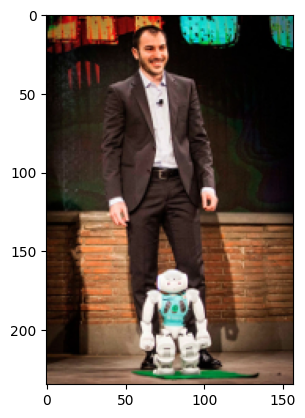

In [4]:
# Carico una immagine statica da url

url = 'https://web.unibas.it/bloisi/assets/images/bloisi_nao.jpg'
#url = 'https://previews.123rf.com/images/mimagephotography/mimagephotography1411/mimagephotography141100024/33214727-full-body-portrait-of-a-handsome-young-african-american-man-smiling-on-isolated-white-background.jpg'

img = Image.open(urlopen(url)).convert('RGB')
plt.grid(False)
_= plt.imshow(img)

In [5]:
# Adatto l'immagine alle dimensioni di un tensore PyTorch 

# Ridimensiono l'immagine
resize = transforms.Resize([224, 224])
img = resize(img)
to_tensor = transforms.ToTensor()

# Trasformo l'immagine in un tensore
tensor = to_tensor(img)
# torch.Size([3, 224, 224])

# Aggiungo un'altra dimensione per far corrispondere la shape del tensore alla shape (NCHW) di un tensore PyTorch
tensor = tensor.unsqueeze(0)
# torch.Size([1, 3, 224, 224])

In [6]:
# Inferisco i Keypoints dall'immagine

output, keypoints = inference(model, tensor)
embedding = assocEmbedding(keypoints)
restricted_keypoints = [[keypoints[0][0], keypoints[0][1], keypoints[0][2], keypoints[0][3], keypoints[0][4], keypoints[0][5], keypoints[0][6],keypoints[0][7],keypoints[0][13]]]

In [7]:
# Disegno i keypoints inferiti sull'immagine

idx = 0
img = drawKeypoints(tensor[idx], restricted_keypoints[idx])
cv2.imshow("Image Keypoints", img)
cv2.waitKey()
cv2.destroyAllWindows()

In [8]:
# Disegno lo skeleton a partire dai keypoints

idx = 0
img = drawSkeleton(tensor[idx], embedding[idx])
cv2.imshow("Image Keypoints", img)
cv2.waitKey()
cv2.destroyAllWindows()

In [9]:
# Salvo solo i 9 keypoints scelti

d = {'x': [], 'y': [], 'tag':[]}
df_keypoints = pd.DataFrame(data=d)
for i in range(len(restricted_keypoints[0])):
    df_temp = pd.DataFrame(restricted_keypoints[0][i])
    df_keypoints = pd.concat([df_keypoints, df_temp])
df_keypoints.reset_index(drop=True, inplace=True)
df_keypoints.to_csv(file_path_csv_keypoints, index=False)
#df_keypoints.head(10)

PermissionError: [Errno 13] Permission denied: 'D:\\dev\\progetti\\VP\\progetto-visione-percezione\\dataset_keypoints'

In [35]:
# Carico un video da url
url = 'https://www.youtube.com/watch?v=80z9NLFyfQU' # ~20 sec
# url = 'https://www.youtube.com/watch?v=seTu2hiI0kE' # ~8 sec

streams = streamlink.streams(url)

s = streams['360p'] # higher than 360p too much time-consuming
container = av.open(s.url, format='segment')

frames = []
for frame in container.decode(video=0):
    frames.append(frame.to_image().convert('RGB'))
container.close() # don't forget to free memory

In [36]:
# Elaboro i frames
display(len(frames)) # numero di frames (immagini)

# Adatto i frames alle dimensioni di un tensore PyTorch 
resize = transforms.Resize([224, 224])  
to_tensor = transforms.ToTensor() 
tensors = [] # Creo la lista di tensori
for frame in frames:
    frame = resize(frame) # Ridimensiono le dimensioni dei frames
    tensor = to_tensor(frame) # Trasformo il frame in tensore
    tensor = tensor.unsqueeze(0) # Aggiungo un'altra dimensione per far corrispondere la shape del tensore alla shape (NCHW) di un tensore PyTorch
    tensors.append(tensor) # Aggiungo il frame convertito in tensore alla lista di tensori
display(len(tensors))

487

487

In [37]:
# Inferisco i Keypoints dai frame

restricted_keypoints_vec = []
embedding_vec = []
for tensor in tensors:
    output, keypoints = inference(model, tensor)
    embedding = assocEmbedding(keypoints)
    restricted_keypoints = [[keypoints[0][0], keypoints[0][1], keypoints[0][2], keypoints[0][3], keypoints[0][4], keypoints[0][5], keypoints[0][6],keypoints[0][7],keypoints[0][13]]]    
    restricted_keypoints_vec.append(restricted_keypoints)
    embedding_vec.append(embedding)

In [46]:
# Disegno i keypoints inferiti sul frame

idx = 0
for tensor, restricted_keypoints in zip(tensors, restricted_keypoints_vec):
    frame = drawKeypoints(tensor[idx], restricted_keypoints[idx])
    cv2.imshow("Image Keypoints", frame)
    cv2.waitKey()
cv2.destroyAllWindows()

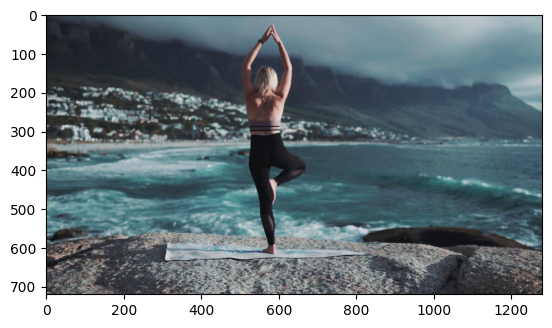